# Transfer Learning for Multi-class Image Classification

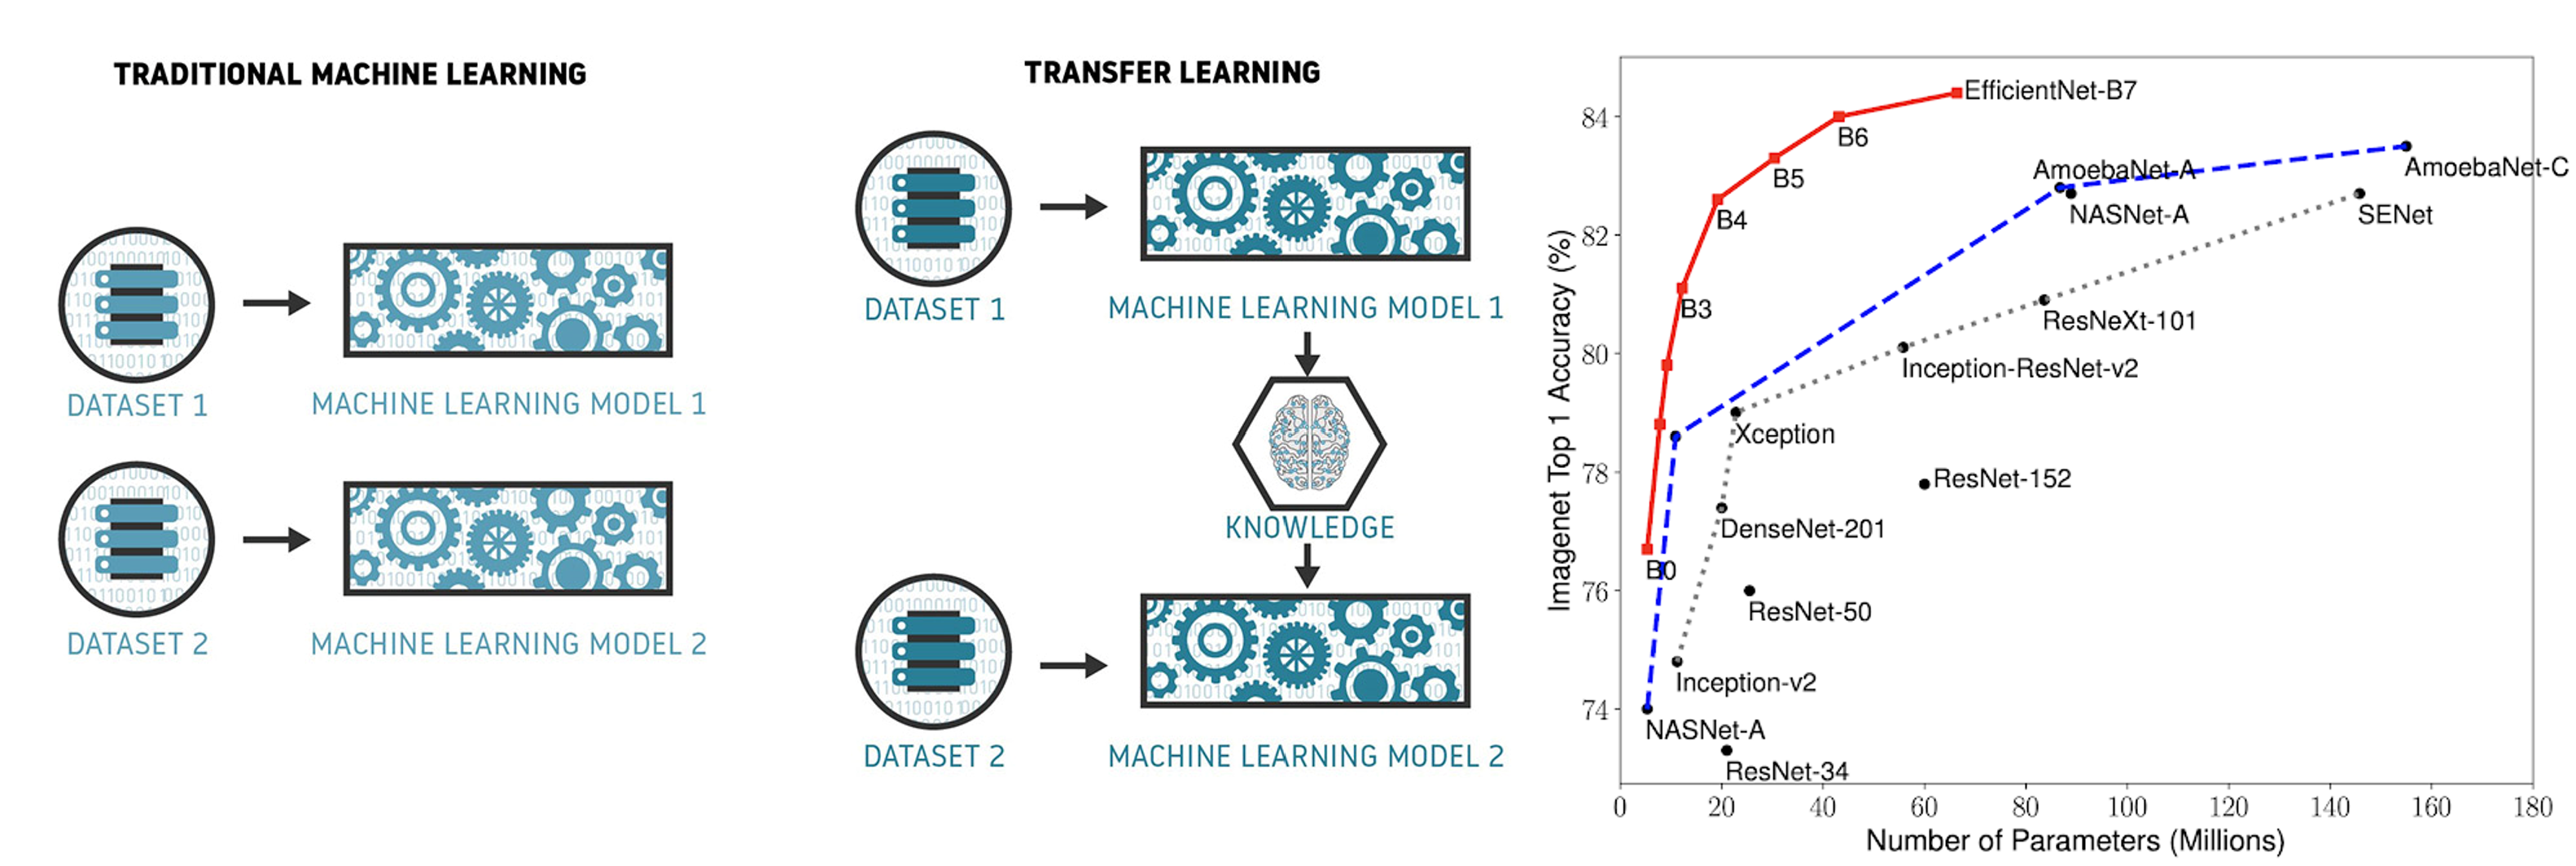

# Dataset Loading tf_flowers

In [8]:
#!pip install matplotlib
import os
import torch
import cv2
import imghdr
import pandas as pd
import tensorflow as tf

import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [9]:
data_dir = 'Dataset'
image_exts = ['jpeg','jpg', 'bmp', 'png']
excluded_files = [".DS_Store", ".Trashes"]

In [11]:
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_path):
        continue  # Skip if not a directory

    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            pass
            #print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [12]:
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)

class_names = data.class_names
print(class_names)

Found 9362 files belonging to 5 classes.
['African_Almond', 'Avocado', 'Cashew', 'Guava', 'Mango']


In [13]:
# Load and augment data
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset='training',
    seed=123
)
val_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset='validation',
    seed=123
)
data = data.map(lambda x, y: (x / 255, y))
val_data = val_data.map(lambda x, y: (x / 255, y))

Found 9362 files belonging to 5 classes.
Using 7490 files for training.
Found 9362 files belonging to 5 classes.
Using 1872 files for validation.


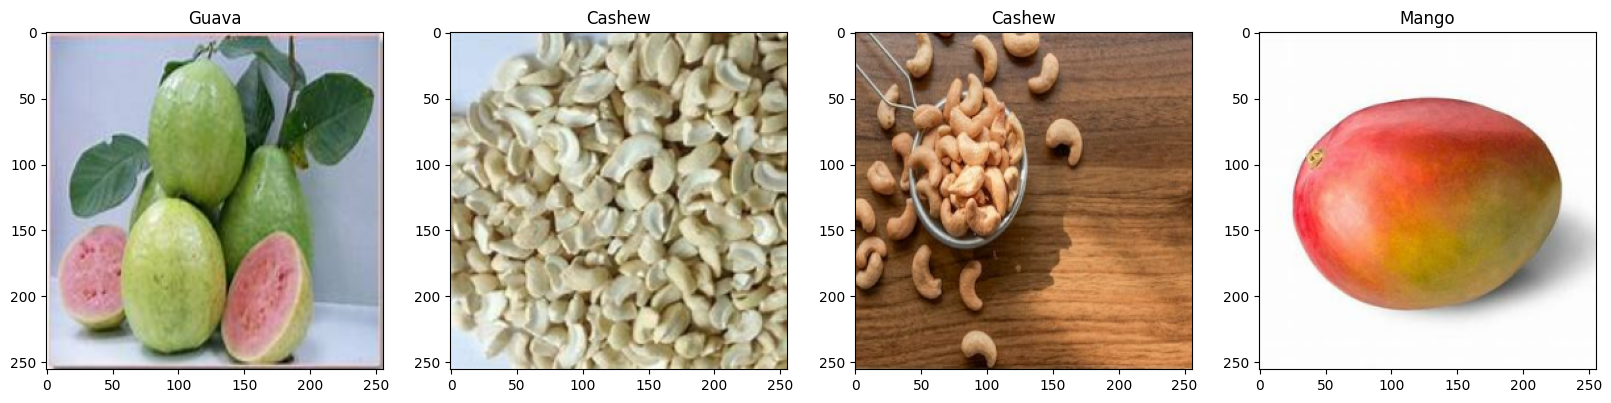

In [14]:
# Display some images
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(class_names[batch[1][idx]])
plt.show()

# Transfer Learning

## Model Improvements with augmentation and VGG16 blocks

## Building Baseline CNN Model

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.

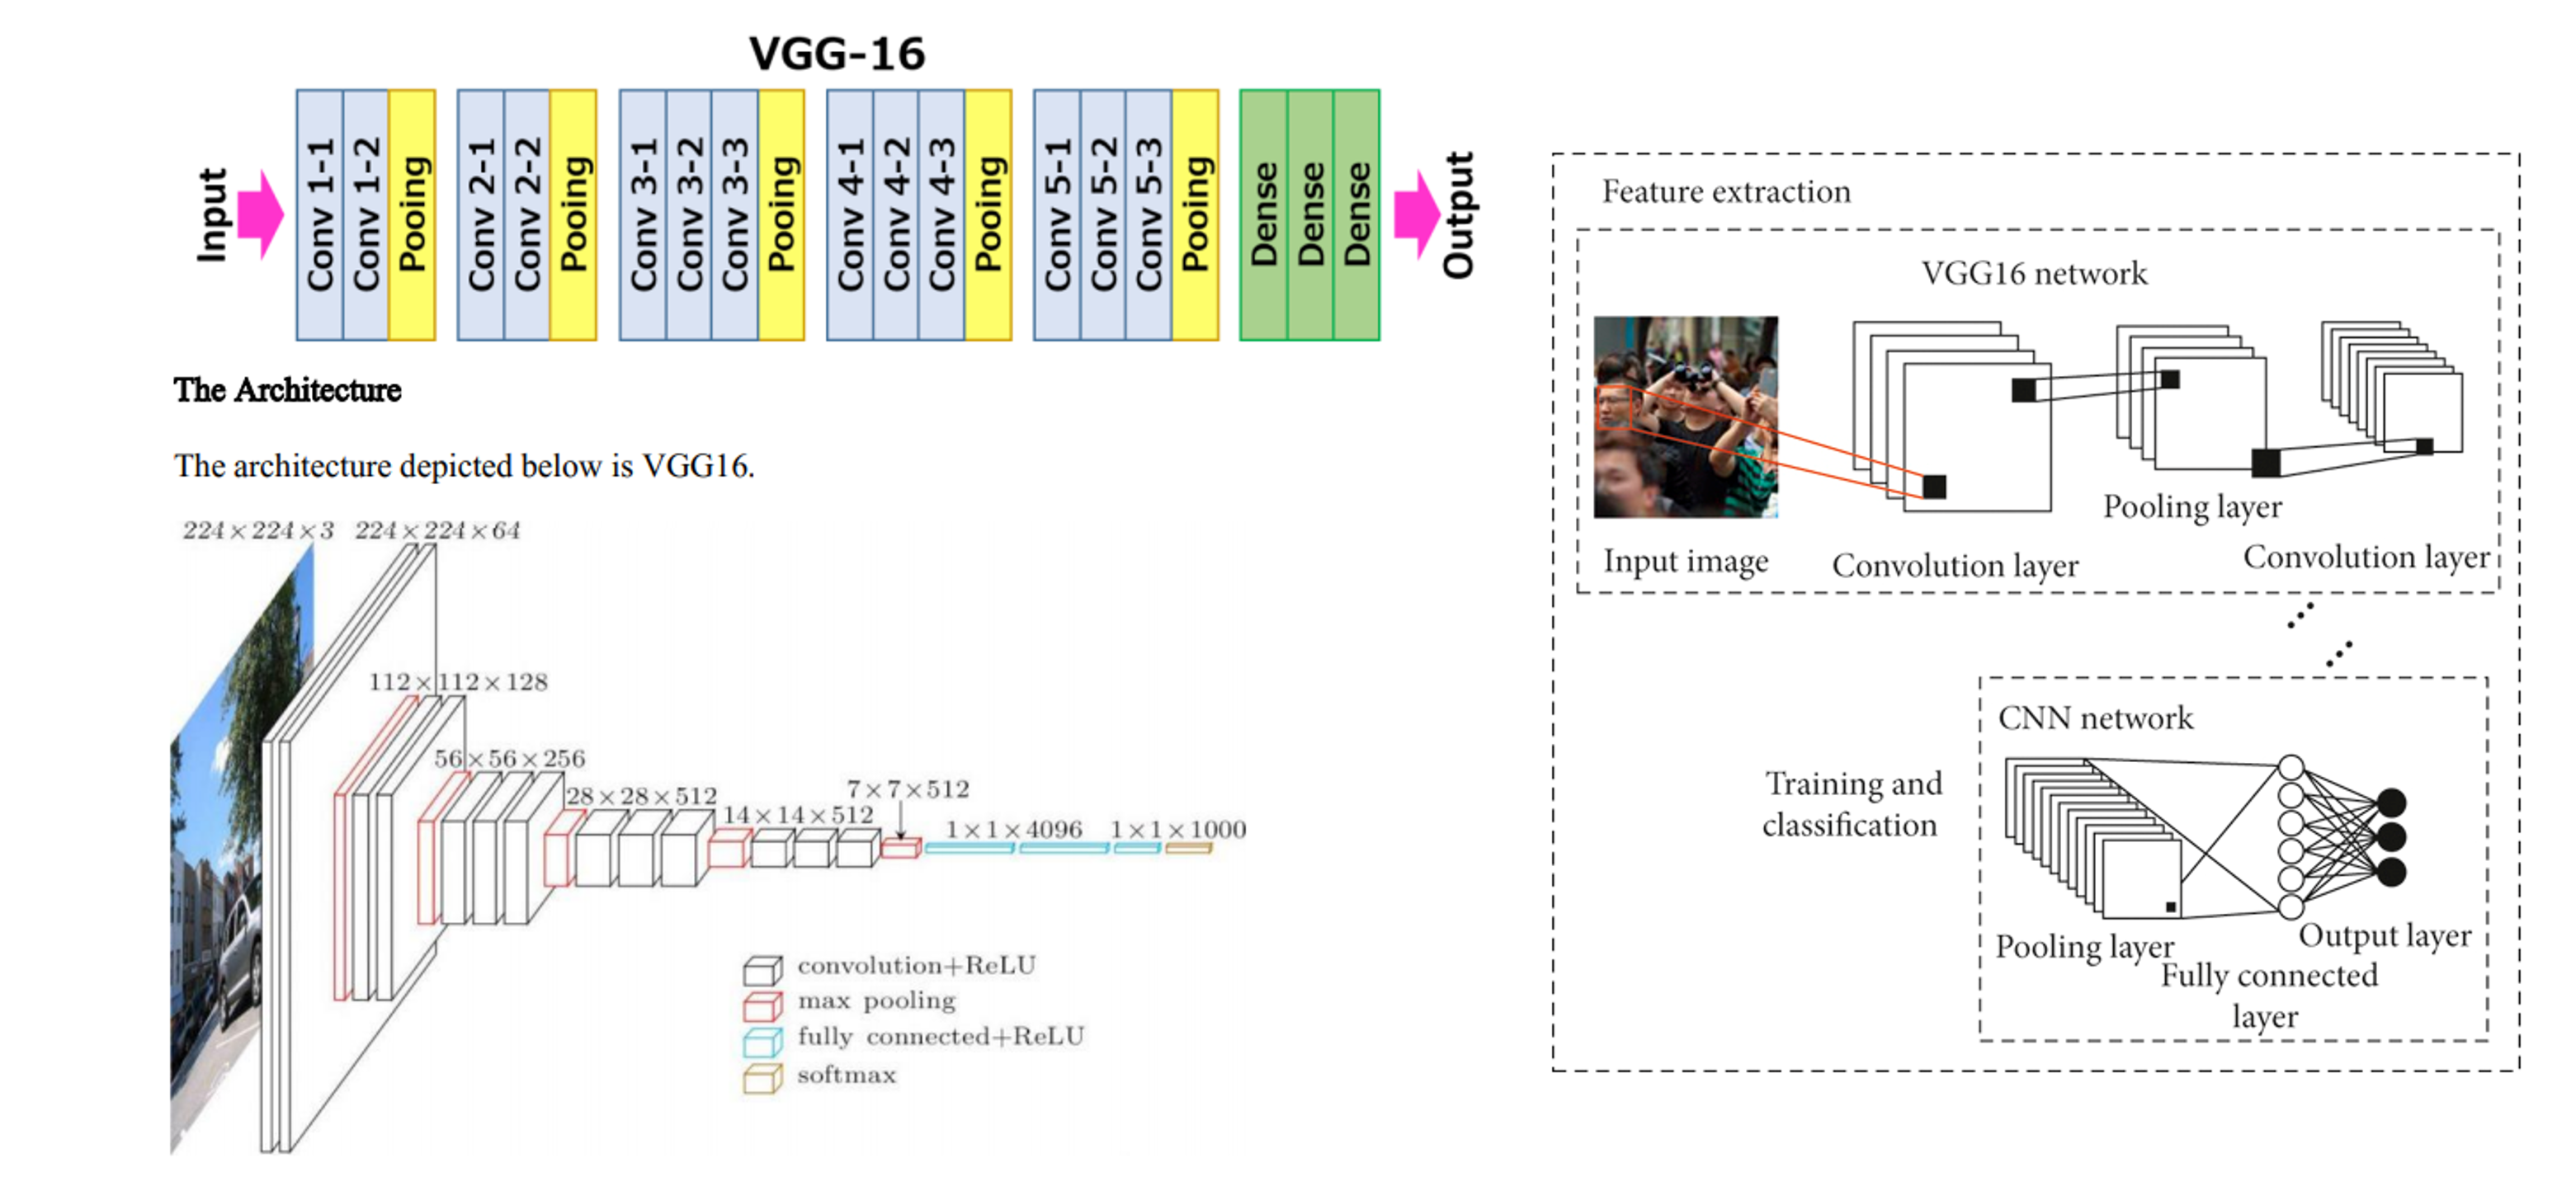

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16

# Load the VGG16 model without the top layer
base_model = VGG16(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers on top of the VGG16 base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  # Adjusted for multiple classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1296s 6s/step - accuracy: 0.4157 - loss: 1.3801 - val_accuracy: 0.7260 - val_loss: 0.8185
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1302s 6s/step - accuracy: 0.7101 - loss: 0.8087 - val_accuracy: 0.8098 - val_loss: 0.6060
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1322s 6s/step - accuracy: 0.7875 - loss: 0.6233 - val_accuracy: 0.8344 - val_loss: 0.5040
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2297s 10s/step - accuracy: 0.8157 - loss: 0.5313 - val_accuracy: 0.8622 - val_loss: 0.4425
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1841s 8s/step - accuracy: 0.8226 - loss: 0.4910 - val_accuracy: 0.8590 - val_loss: 0.4213
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2736s 12s/step - accuracy: 0.8450 - loss: 0.4416 - val_accuracy: 0.8809 - val_loss: 0.3691
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1332s 6s/step - accuracy: 0.8606 - loss: 0.3986 - val_accuracy: 0.8729 - val_loss: 0.3724
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2038s 9s/step - accuracy: 0.8606 - loss: 0.3857 

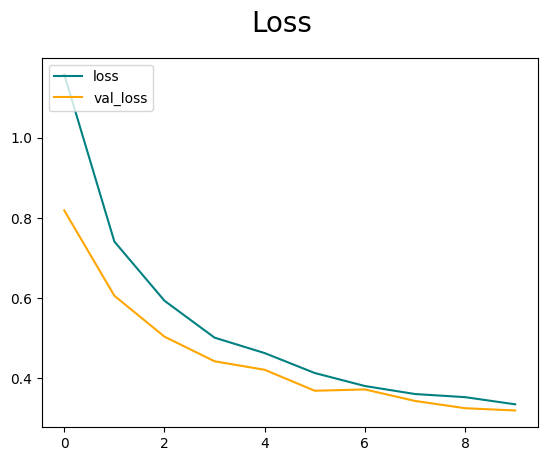

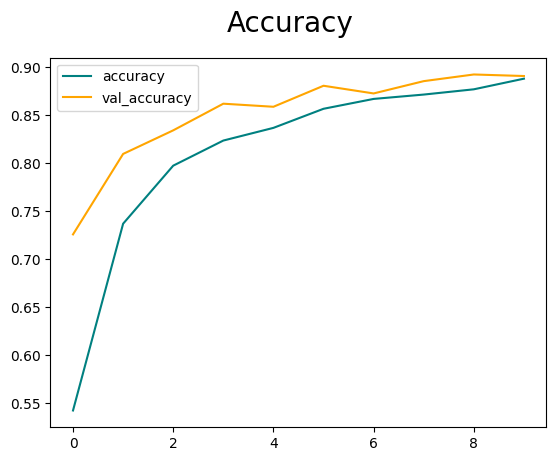

In [17]:
# Train the model
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(data, epochs=10, validation_data=val_data, callbacks=[tensorboard_callback])

# Plot training history
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [27]:
# Evaluate on validation data
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()


In [38]:
# for batch in val_data.as_numpy_iterator():
#     X, y = batch
#     yhat = model.predict(X)
#     pre.update_state(y, yhat)
#     re.update_state(y, yhat)
#     acc.update_state(y, yhat)

# print(f"Precision: {pre.result().numpy()}")
# print(f"Recall: {re.result().numpy()}")
# print(f"Accuracy: {acc.result().numpy()}")

In [29]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history=model.fit(train_generator, epochs=5, validation_data=validation_generator)

In [39]:
model.save('image_classifier.keras')
fruits = tf.keras.models.load_model('image_classifier.keras')

In [40]:
fruits.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,979,916 (57.14 MB)

 Trainable params: 132,613 (518.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 132,615 (518.03 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Predicted Class: Avocado


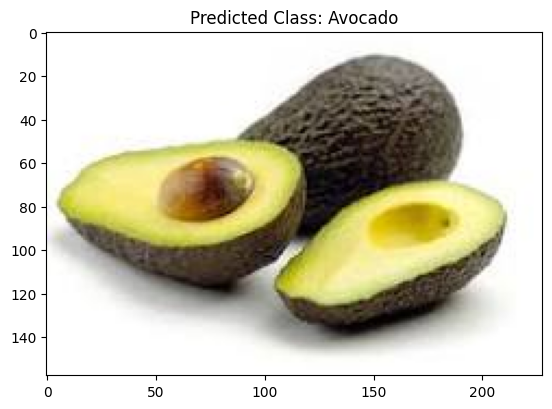

In [52]:
import cv2
import numpy as np

# Function to predict and display the class of an image
def predict_and_show_image(image_path, model, class_names):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))  # Resize to match model input
    img = np.reshape(img, [1, 256, 256, 3])  # Reshape for model input
    img = img / 255.0  # Normalize the image

    # Predict the class of the image
    preds = model.predict(img)

    # Get the index of the predicted class
    max_idx = np.argmax(preds)

    # Get the predicted class name
    predicted_class = class_names[max_idx]

    # Display the predicted class
    print(f"Predicted Class: {predicted_class}")

    # Show the image
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Class: {predicted_class}")
    plt.show()

# Define your class names (ensure this matches the order in your model's output)
class_names = ['African_Almond', 'Avocado', 'Cashew', 'Guava', 'Mango']

# Use the function to predict and display the class of an image
predict_and_show_image('avocado.jpeg', model, class_names)
